In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# preparing cifar10 dataset
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256, shuffle=True)

In [ ]:
eps = 0.05
alpha = 0.005
steps = 50
std= 0.039

Text(0.5, 0.98, 'CIFAR10 dataset')

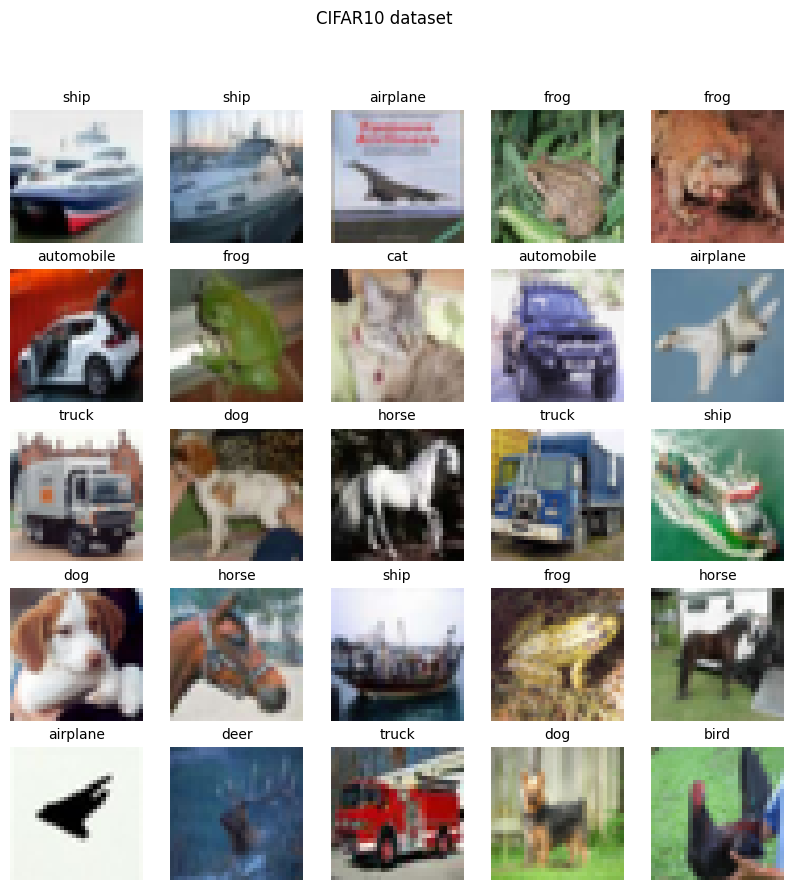

In [ ]:
fig = plt.figure(figsize=(10, 10))
n_rows = 5
n_cols = 5
for index in range(1, n_rows * n_cols + 1):
  plt.subplot(n_rows, n_cols, index)
  plt.axis('off')
  plt.imshow(test_data.data[index])
  title = f'{test_data.classes[test_data[index][1]]}'
  plt.title(title, fontsize=10)
plt.suptitle('CIFAR10 dataset')

In [ ]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()

    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
    self.pool1 = nn.MaxPool2d(2)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
    self.pool2 = nn.MaxPool2d(2)
    self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
    self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
    self.pool3 = nn.MaxPool2d(2)
    self.dr1 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(128 * 4 * 4, 1024)
    self.dr2 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(1024, 512)
    self.dr3 = nn.Dropout(0.5)
    self.fc3 = nn.Linear(512, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.pool1(x)
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = self.pool2(x)
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))
    x = self.pool3(x)
    x = x.view(-1, np.prod(x.size()[1:]))
    x = self.dr1(x)
    x = F.relu(self.fc1(x))
    x = self.dr2(x)
    x = F.relu(self.fc2(x))
    x = self.dr3(x)
    logits = self.fc3(x)
    probs = F.softmax(logits, dim=1)
    return logits, probs

In [ ]:
# implementation of BIM attack based on torchattacks(https://github.com/Harry24k/adversarial-attacks-pytorch)

def BIM(model, loss_fn, images, labels, eps, alpha, steps, device):
  #images = images.clone().detach().to(device)
  #labels = labels.clone().detach().to(device)

  original_images = images.clone().detach()
  images_min = original_images - eps
  images_max = original_images + eps

  images.requires_grad = True

  for i in range(steps):
    outputs, _ = model(images)

    cost = loss_fn(outputs, labels)
    grad = torch.autograd.grad(cost, images, retain_graph=False, create_graph=False)[0]

    adv_images = images + alpha * grad.sign()
    adv_images = torch.clamp(adv_images, min=images_min, max=images_max)
    images = torch.clamp(adv_images, min=0, max=1)

  return images

In [ ]:
def gn(images, std):
  # images = images.clone().detach().to(device)

  noisy_images = images + std * torch.randn_like(images)
  noisy_images = torch.clamp(noisy_images, min=0, max=1)

  return noisy_images

In [ ]:
def run_test(model, test_loader, device):
  num_correct = 0

  model.eval()

  for X, y_true in test_loader:
    X = X.to(device)
    y_true = y_true.to(device)

    with torch.no_grad():
      y_hat, y_hat_probs = model(X)

    y_labels = torch.argmax(y_hat_probs, 1)

    num_correct += (y_labels == y_true).sum()

  model_accuracy = num_correct / len(test_loader.dataset)

  return model, model_accuracy

In [ ]:
def run_bim(model, loss_fn, test_loader, eps, alpha, steps, device):
  num_correct = 0
  diff = torch.empty(0)

  model.eval()

  for X, y_true in test_loader:
    X = X.to(device)
    y_true = y_true.to(device)
    pert_data = BIM(model, loss_fn, X, y_true, eps, alpha, steps, device)
    with torch.no_grad():
      y_hat, y_hat_probs = model(pert_data)
    y_labels = torch.argmax(y_hat_probs, 1)

    num_correct += (y_labels == y_true).sum()

    diff = torch.cat((diff, X.reshape((len(X), -1)).cpu() - pert_data.reshape((len(X), -1)).cpu()))

  adv_accuracy = num_correct / len(test_loader.dataset)
  pert_norm = torch.linalg.norm(diff, dim=1).mean()

  return model, adv_accuracy, pert_norm

In [ ]:
def run_gn(model, test_loader, std, device):
  num_correct = 0

  model.eval()

  for X, y_true in test_loader:
    X = X.to(device)
    y_true = y_true.to(device)
    pert_data = gn(X, std)
    with torch.no_grad():
      y_hat, y_hat_probs = model(pert_data)
    y_labels = torch.argmax(y_hat_probs, 1)

    num_correct += (y_labels == y_true).sum()

  noisy_accuracy = num_correct / len(test_loader.dataset)

  return model, noisy_accuracy

In [ ]:
def craft_detection_dataset(model, loss_fn, test_loader, eps, alpha, std, steps, device):
  X_clean = torch.empty((0, 3, 32, 32))
  y_clean = torch.empty(0)

  X_adv = torch.empty((0, 3, 32, 32))
  y_adv = torch.empty(0)

  X_noisy = torch.empty((0, 3, 32, 32))
  y_noisy = torch.empty(0)

  model.eval()

  for X, y_true in test_loader:
    X = X.to(device)
    y_true = y_true.to(device)

    with torch.no_grad():
      y_hat, y_hat_probs = model(X)
    y_labels = torch.argmax(y_hat_probs, 1)

    # idx_correct = torch.nonzero(y_labels == y_true)
    # X = X[idx_correct]
    # y_labels = y_labels[idx_correct]

    X = X[y_labels == y_true]
    y_labels = y_labels[y_labels == y_true]

    pert_adv = BIM(model, loss_fn, X, y_labels, eps, alpha, steps, device)
    pert_noisy = gn(X, std)

    with torch.no_grad():
      _, adv_probs = model(pert_adv)
      _, noisy_probs = model(pert_noisy)

    adv_labels = torch.argmax(adv_probs, 1)
    noisy_labels = torch.argmax(noisy_probs, 1)

    X_clean = torch.cat((X_clean, X.cpu()))
    y_clean = torch.cat((y_clean, y_labels.cpu()))

    X_adv = torch.cat((X_adv, pert_adv.cpu()))
    y_adv = torch.cat((y_adv, adv_labels.cpu()))

    X_noisy = torch.cat((X_noisy, pert_noisy.cpu()))
    y_noisy = torch.cat((y_noisy, noisy_labels.cpu()))

  return X_clean, y_clean, X_adv, y_adv, X_noisy, y_noisy

In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
model = ConvNet().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/ConvNetCIFAR.pt'))

<All keys matched successfully>

In [ ]:
model, model_accuracy = run_test(model, test_loader, device)
print(f'Model accuracy on clean samples: {model_accuracy * 100:.2f}%')

Model accuracy on clean samples: 80.32%


In [ ]:
model, adv_accuracy, pert_norm = run_bim(model, loss_fn, test_loader, eps, alpha, steps, device)
print(f'Model accuracy on adversarial samples (BIM): {adv_accuracy * 100:.2f}%')
print(f'Average L2-perturbation: {pert_norm:.2f}')

Model accuracy on adversarial samples (BIM): 0.44%
Average L2-perturbation: 2.12


In [ ]:
model, noisy_accuracy = run_gn(model, test_loader, std, device)
print(f'Model accuracy on noisy samples: {noisy_accuracy * 100:.2f}%')

Model accuracy on noisy samples: 77.19%


In [ ]:
torch.cuda.empty_cache()

In [ ]:
# results from Feinman are successfully replicated
# crafting data for detection
X_clean, y_clean, X_adv, y_adv, X_noisy, y_noisy = craft_detection_dataset(
                                                      model, loss_fn, test_loader, 
                                                      eps, alpha, std, steps, device)

Text(0.5, 0.98, 'Predictions for BIM images')

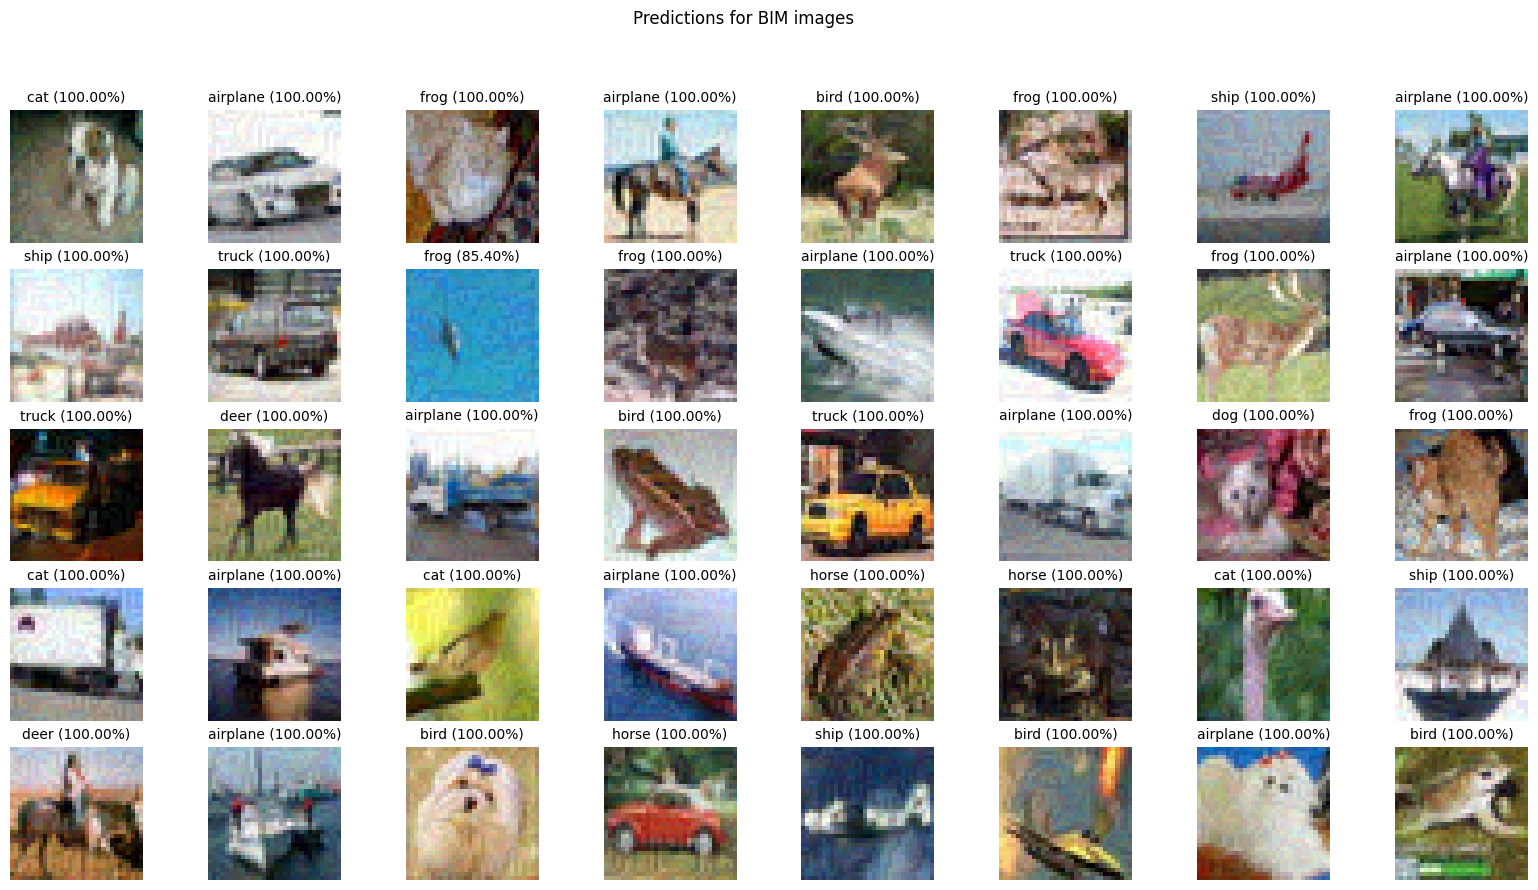

In [ ]:
n_cols = 8
n_rows = 5

fir = plt.figure(figsize=(20, 10))
for index in range(1, n_cols * n_rows + 1):
  plt.subplot(n_rows, n_cols, index)
  plt.axis('off')
  plt.imshow(X_adv[index].detach().movedim(0, -1))

  with torch.no_grad():
    model.eval()
    __, probs = model(X_adv[index].unsqueeze(0).to(device))
    title = f'{test_data.classes[torch.argmax(probs, 1)]} ({torch.max(probs) * 100:.2f}%)'
    plt.title(title, fontsize=10)
plt.suptitle('Predictions for BIM images')

In [ ]:
# TODO: visualize clean, noisy and adv images side-by-side

In [ ]:
# implementing bayesian uncertainty method

from numpy import ceil

def get_mc_predictions(model, images, batch_size=256, num_iter=50):
  output_dim = 10

  model.train()

  def predict():
    num_batches = int(ceil(images.shape[0] / float(batch_size)))
    output = torch.zeros(size=(images.shape[0], output_dim))
    with torch.no_grad():
      for i in range(num_batches):
        output[i * batch_size:(i + 1) * batch_size], __ = model(images[i * batch_size:(i + 1) * batch_size].to(device))

    return output

  predictions_mc = torch.empty(0, images.shape[0], output_dim)

  for i in range(num_iter):
    predictions_mc = torch.cat((predictions_mc, predict().unsqueeze(0)))

  return predictions_mc

In [ ]:
uncerts_clean = get_mc_predictions(model, X_clean).var(dim=0).mean(dim=1)
uncerts_noisy = get_mc_predictions(model, X_noisy).var(dim=0).mean(dim=1)
uncerts_adv = get_mc_predictions(model, X_adv).var(dim=0).mean(dim=1)

In [ ]:
# imports for detector
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import scale

In [ ]:
def train_detector(uncerts_neg, uncerts_pos):
  values = torch.cat((uncerts_neg, uncerts_pos)).reshape(-1, 1)
  values = scale(values)
  labels = torch.cat((torch.zeros_like(uncerts_neg), torch.ones_like(uncerts_pos)))

  lr = LogisticRegressionCV().fit(values, labels)

  return values, labels, lr

In [ ]:
def compute_roc(probs_neg, probs_pos, plot=False):
  probs = torch.cat((probs_neg, probs_pos))
  labels = torch.cat((torch.zeros_like(probs_neg), torch.ones_like(probs_pos)))

  fpr, tpr, _ = roc_curve(labels, probs)
  auc_score = auc(fpr, tpr)

  if plot:
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, color='blue',
             label='ROC (AUC = %0.4f)' % auc_score)
    plt.legend(loc='lower right')
    plt.title("ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()

  return fpr, tpr, auc_score

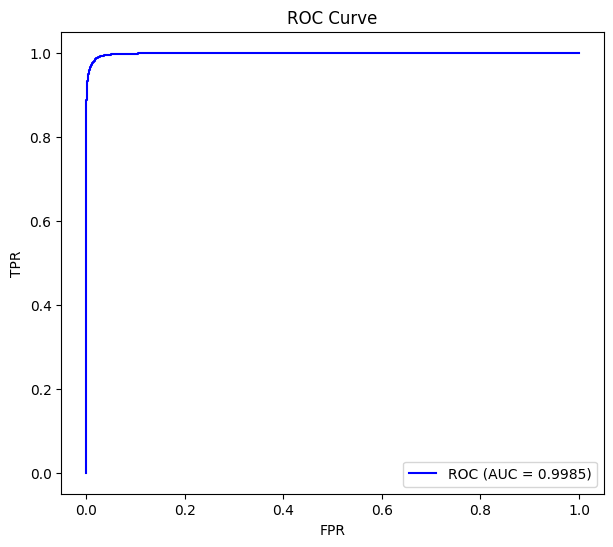

In [ ]:
values, labels, detector = train_detector(torch.cat((uncerts_clean, uncerts_noisy)), uncerts_adv)
probabilities = torch.tensor(detector.predict_proba(values)[:, 1])
__, __, auc_score = compute_roc(probabilities[:2 * len(X_clean)], probabilities[2 * len(X_clean):], plot=True)